# Zel'dovich Control Variates (ZCV)

The purpose of applying the method of Zel'dovich Control Variates (ZCV) to the power spectrum or correlation function multipoles is to reduce the variance on these measurements. Details about the method can be found in Kokron et al. 2022 (arXiv:2205.15327), DeRose et al. 2023 (arXiv:2210.14239) and Hadzhiyska et al. 2023 (in prep.). 

Currently, Zel'dovich analytic prediction is only available for the Legendre multipoles `ell = 0, 2, 4`, so we request that the user specify a subset of those or the full set under `poles` in `power_params`. This also implies that `nbins_mu` in `power_params` must be set to 1.

Other important ZCV parameters (`zcv_params`) are `nmesh` which needs to match `nmesh` in `power_params` (the latter can be left blank and will be automatically set in `abacus_hod.py`). `nmesh` should also match the number of cells of the initial conditions displacement and density fields (currently, we save `nmesh = 576, 1152` for each box). `kcut` is the Gaussian cut-off scale, which we typically set to half the Nyquist frequency. Finally, `fields` specifies the Zel'dovich templates that will be used to fit the tracer power spectrum. The full set contains `"1cb", "delta", "delta2", "tidal2", "nabla2"`, and if requesting only a subset of those, the ordering should be contiguous starting with `"1cb"`. Since the Zel'dovich approximation breaks down rather quickly, for most cases, it is sufficient to only include the fields up to `"delta"` or `"delta2"`. The optional parameter `kmax_fit` determines the maximum k-value to which we fit the biases. There are also several parameter controlling the smoothness of the CV variable `beta` (`sg_window`, `dk_window`, `k0_window` and `beta1_k`), which if not specified, are automatically set to values reasonable for most applications. Note that the function `apply_zcv` returns the full bias vector, corresponding to `b1, b2, bs, bn, shotnoise`, where we output zeros for all biases corresponding to fields that are not requested.

When applying ZCV reduction on the correlation function, the following conditions must be met: `k_hMpc_max == np.pi*nmesh/Lbox`, `logk == False`, `nbins_k == nmesh//2` and `n_mu_bins == 1`. If not specified by the user, the code should automatically assign these values or output an error message.

The first step in applying the ZCV method is running the "preparation steps." Below, we provide full instructions for how to do this.

1. Save the window function (given k-binning) and the Zel'dovich theoretical prediction (given k-binning and redshift):

`python -m abacusnbody.hod.zcv.zenbu_window --path2config $1 --alt_simname $2`

    - If in addition applying ZCV to the correlation function multipoles, run:
    
    `python -m abacusnbody.hod.zcv.zenbu_window --path2config $1 --alt_simname $2 --want_xi`

2. Save the initial conditions fields (delta, delta^2, s^2, nabla^2):

`python -m abacusnbody.hod.zcv.ic_fields --path2config $1 --alt_simname $2`

3. Save the advected fields and their power spectra at this redshift

    - When applying ZCV to the power spectrum multipoles:

        - Run this version if planning to use mocks with and without RSD effects:

        `python -m abacusnbody.hod.zcv.advect_fields --path2config $1 --want_rsd --alt_simname $2`

        - Run this version if not planning to use mocks with RSD effects:

        `python -m abacusnbody.hod.zcv.advect_fields --path2config $1 --alt_simname $2`

    - When applying ZCV to the correlation function multipoles:

        - Run this version if planning to use mocks with and without RSD effects:

        `python -m abacusnbody.hod.zcv.advect_fields --path2config $1 --want_rsd --alt_simname $2 --save_3D_power`

        - Run this version if not planning to use mocks with RSD effects:

        `python -m abacusnbody.hod.zcv.advect_fields --path2config $1 --alt_simname $2 --save_3D_power`
        
An example `yaml` configuration file can be found in the `config/` directory, `lrg_hod_base_z0.500_nmesh576.yaml`. Note that the `--alt_simname` argument is optional and only needed if the user wants to use a different simulation from the one specified in the `yaml` file.


In [1]:
# Load necessary packages
import os

import numpy as np
import matplotlib.pyplot as plt
import yaml

from abacusnbody.hod.abacus_hod import AbacusHOD

In [2]:
# Whether to use the last computed tracer power spectra (saves time)
load_presaved = False

In [3]:
# Load the config file and parse in relevant parameters
path2config = "config/lrg_hod_base_z0.500_nmesh576.yaml"

# Read the parameters from the yaml file
config = yaml.safe_load(open(path2config))
sim_params = config['sim_params']
HOD_params = config['HOD_params']
clustering_params = config['clustering_params']
zcv_params = config['zcv_params']

# Additional parameter choices
want_rsd = HOD_params['want_rsd']
write_to_disk = HOD_params['write_to_disk']
z_mock = sim_params['z_mock']
sim_name = sim_params['sim_name']
nmesh = zcv_params['nmesh']

In [4]:
# Run hod
newBall = AbacusHOD(sim_params, HOD_params, clustering_params)
mock_dict = newBall.run_hod(newBall.tracers, want_rsd, write_to_disk, Nthread=16)
nobj = mock_dict['LRG']['mass'].size
print("number of galaxies", nobj)

Loading simulation by slab,  0
Loading simulation by slab,  1
Loading simulation by slab,  2
Loading simulation by slab,  3
Loading simulation by slab,  4
Loading simulation by slab,  5
Loading simulation by slab,  6
Loading simulation by slab,  7
Loading simulation by slab,  8
Loading simulation by slab,  9
Loading simulation by slab,  10
Loading simulation by slab,  11
Loading simulation by slab,  12
Loading simulation by slab,  13
Loading simulation by slab,  14
Loading simulation by slab,  15
Loading simulation by slab,  16
Loading simulation by slab,  17
Loading simulation by slab,  18
Loading simulation by slab,  19
Loading simulation by slab,  20
Loading simulation by slab,  21
Loading simulation by slab,  22
Loading simulation by slab,  23
Loading simulation by slab,  24
Loading simulation by slab,  25
Loading simulation by slab,  26
Loading simulation by slab,  27
Loading simulation by slab,  28
Loading simulation by slab,  29
Loading simulation by slab,  30
Loading simulation

In [5]:
# Run zcv on the power spectrum multipoles
zcv_dict = newBall.apply_zcv(mock_dict, config, load_presaved=load_presaved)
print(zcv_dict.keys())
for key in zcv_dict.keys():
    if "Pk" in key:
        print(key, zcv_dict[key][:, :10])
        print("-----------------")

D =  58.898568747251055
min/max tracer pos 0.0 1999.9994 (2851468, 3)


/global/u1/b/boryanah/repos/abacusutils/abacusnbody/analysis/power_spectrum.py:588: UserWarning: npartition 288 not large enough to use all 256 threads; should be 2*nthread
  tsc_parallel(pos, field, Lbox, weights=w)


field, pos float32 float32


/global/u1/b/boryanah/repos/abacusutils/abacusnbody/analysis/power_spectrum.py:586: UserWarning: npartition 288 not large enough to use all 256 threads; should be 2*nthread
  tsc_parallel(pos + np.float32(d), field, Lbox, weights=w)


shift float32 float32
field fft complex64
Computing auto-correlation of tracer
Computing cross-correlation of tracer and  1cb
Computing cross-correlation of tracer and  delta
gen mocks 0.46642112731933594
D =  58.898568747251055
min/max tracer pos 0.00012207031 1999.9994 (2851468, 3)


/global/u1/b/boryanah/repos/abacusutils/abacusnbody/analysis/power_spectrum.py:588: UserWarning: npartition 288 not large enough to use all 256 threads; should be 2*nthread
  tsc_parallel(pos, field, Lbox, weights=w)


field, pos float32 float32


/global/u1/b/boryanah/repos/abacusutils/abacusnbody/analysis/power_spectrum.py:586: UserWarning: npartition 288 not large enough to use all 256 threads; should be 2*nthread
  tsc_parallel(pos + np.float32(d), field, Lbox, weights=w)


shift float32 float32
field fft complex64
Computing auto-correlation of tracer
Computing cross-correlation of tracer and  1cb
Computing cross-correlation of tracer and  delta
zeros in the measured power spectra =  0 3456 864
zeros in the measured power spectra =  0 10368 2592
bias [1.00000000e+00 9.91593878e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.40394709e+03]
dict_keys(['k_binc', 'poles', 'rho_tr_ZD', 'rho_tr_ZD_sn_lim', 'Pk_ZD_ZD_ell', 'Pk_tr_ZD_ell', 'Pk_tr_tr_ell', 'Nk_tr_tr_ell', 'Pk_tr_tr_ell_zcv', 'Pk_ZD_ZD_ell_ZeNBu', 'bias'])
Pk_ZD_ZD_ell [[ 51846.4118589   28547.01288313  63369.3990674   65156.66968237
   73664.75750497  68726.76759015  66153.33595083  71303.95179111
   58044.78112957  53687.82978115]
 [217186.81095903  16981.44693907  30356.36199179  78428.67031589
   29731.83492904  33525.4805439   31147.88947603  40479.78992266
   16639.779122    18464.40769471]
 [435083.80210592  -7306.50971393 -25077.74117642   -598.28280476
   23294.92010325 -18654.5527025  

In [6]:
# Run zcv on the correlation function multipoles
zcv_dict_xi = newBall.apply_zcv_xi(mock_dict, config, load_presaved=load_presaved)
print(zcv_dict_xi.keys())
for key in zcv_dict_xi.keys():
    if "Xi" in key:
        print(key, zcv_dict_xi[key][:, :10])
        print("-----------------")

D =  58.898568747251055
min/max tracer pos 0.0 1999.9994 (2851468, 3)
field, pos float32 float32
shift float32 float32
field fft complex64
Computing auto-correlation of tracer
Computing cross-correlation of tracer and  1cb
Computing cross-correlation of tracer and  delta
gen mocks 0.46341633796691895
D =  58.898568747251055
min/max tracer pos 0.00012207031 1999.9994 (2851468, 3)
field, pos float32 float32
shift float32 float32
field fft complex64
Computing auto-correlation of tracer
Computing cross-correlation of tracer and  1cb
Computing cross-correlation of tracer and  delta


/global/u1/b/boryanah/repos/abacusutils/abacusnbody/hod/zcv/tools_cv.py:592: UserWarning: Setting the parameters correctly for Xi computation
  warnings.warn("Setting the parameters correctly for Xi computation")


Projecting 1cb 1cb
Projecting delta 1cb
Projecting delta delta
bias [1.00000000e+00 9.97573409e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.30406033e-07]
Compressed
dict_keys(['k_binc', 'poles', 'rho_tr_ZD', 'Pk_ZD_ZD_ell', 'Pk_tr_ZD_ell', 'Pk_tr_tr_ell', 'Nk_tr_tr_ell', 'Pk_tr_tr_ell_zcv', 'Pk_ZD_ZD_ell_ZeNBu', 'bias', 'Xi_tr_tr_ell_zcv', 'Xi_tr_tr_ell', 'Np_tr_tr_ell', 'r_binc'])
Xi_tr_tr_ell_zcv [[  81.43629       0.            0.            5.4717236     3.7121673
     0.            2.689001      1.178847      1.2678285     1.2842284 ]
 [-203.59071       0.            0.            4.2962055    -0.35421377
     0.            0.8991501    -0.54169625   -0.27910763   -0.31785497]
 [ 274.84747       0.            0.           31.948708     -4.2080684
     0.            3.1925206     1.3314441    -1.6291361    -1.0895718 ]]
-----------------
Xi_tr_tr_ell [[  81.40318       0.            0.            5.5085707     3.7155805
     0.            2.6903267     1.1835886     1.274286

In [7]:
# Parse the output from the ZCV-reduced power spectrum measurements
k_binc = zcv_dict['k_binc']
pk_nn_betasmooth = zcv_dict['Pk_tr_tr_ell_zcv']
pk_tt_poles = zcv_dict['Pk_tr_tr_ell']
pk_zz = zcv_dict['Pk_ZD_ZD_ell']
pk_zn = zcv_dict['Pk_tr_ZD_ell']
r_zt = zcv_dict['rho_tr_ZD']
pk_zenbu = zcv_dict['Pk_ZD_ZD_ell_ZeNBu']

Plot the ZCV reduction on the power spectrum.

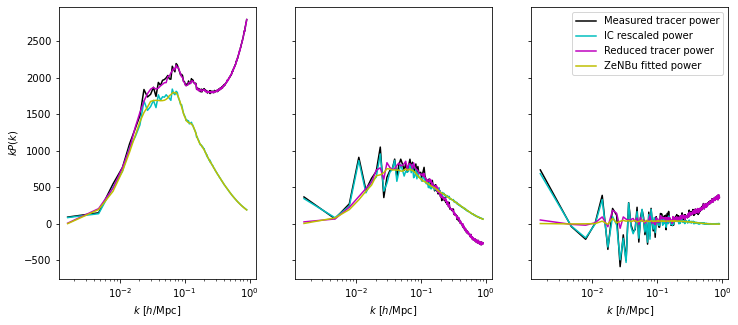

In [8]:
# Set up the canvas
cs = ['k', 'c', 'm', 'y']
if want_rsd:
    figsize = (12, 5)
    n_ell = 3
else:
    figsize = (6, 5)
    n_ell = 1
f, ax = plt.subplots(1, n_ell, sharex=True, sharey=True, figsize=figsize)
if not want_rsd:
    ax = [ax]
    
# Loop over all multipoles
for ell in range(n_ell):
    
    if want_rsd:
        pk_zz_ell = pk_zz[ell, :].flatten()
        pk_zenbu_ell = pk_zenbu[ell, :].flatten()
        pk_tt_poles_ell = pk_tt_poles[ell, :]
        pk_nn_betasmooth_ell = pk_nn_betasmooth[ell, :]
    else:
        pk_zz_ell = pk_zz.flatten()
        pk_zenbu_ell = pk_zenbu.flatten()
        pk_tt_poles_ell = pk_tt_poles.flatten()
        pk_nn_betasmooth_ell = pk_nn_betasmooth.flatten()
        
    ax[ell].plot(k_binc, k_binc * pk_tt_poles_ell, c=cs[0], label='Measured tracer power')
    ax[ell].plot(k_binc, k_binc * pk_zz_ell, c=cs[1], label='IC rescaled power')
    ax[ell].plot(k_binc, k_binc * pk_nn_betasmooth_ell, c=cs[2], label='Reduced tracer power')
    ax[ell].plot(k_binc, k_binc * pk_zenbu_ell, c=cs[3], label='ZeNBu fitted power')
    
    if ell == 0:
        ax[ell].set_ylabel(r"$k P(k)$")
    ax[ell].set_xlabel(r"$k \ [h/{\rm Mpc}]$")
plt.xscale('log')
plt.legend()


(1.0, 200.0)

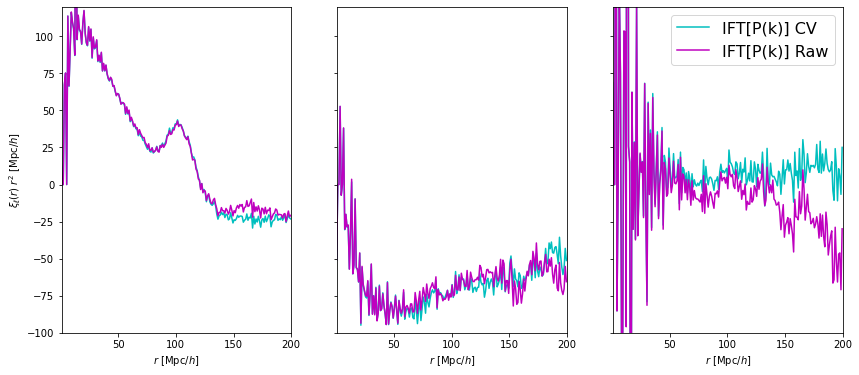

In [9]:
# read ZCV output
r_binc = zcv_dict_xi['r_binc']
xi = zcv_dict_xi['Xi_tr_tr_ell_zcv'].reshape(3, len(r_binc))
xi_raw = zcv_dict_xi['Xi_tr_tr_ell'].reshape(3, len(r_binc))

# plot Xi
n_ell = 3
figsize = (14, 6)
f, ax = plt.subplots(1, n_ell, sharex=True, sharey=True, figsize=figsize)
for ell in range(n_ell):
    ax[ell].plot(r_binc, xi[ell]*r_binc**2, cs[1], label='IFT[P(k)] CV')
    ax[ell].plot(r_binc, xi_raw[ell]*r_binc**2, cs[2], label='IFT[P(k)] Raw')
    ax[ell].set_xlabel(r"$r \ [{\rm Mpc}/h]$")
    if ell == 0:
        ax[ell].set_ylabel(r"$\xi_\ell(r) \  r^2 \ [{\rm Mpc}/h]$")
plt.legend(fontsize=16)
plt.ylim([-100, 120])
plt.xlim([1, 200])

Note that inverse Fourier transforming the 3D power spectrum into a 3D Xi and converting those into Legendre polynomials introduces a lot of noise on small scales. For this reason, we recommend supplementing the correlation function measurement below r <= 50 Mpc/h with a brute-force pair counting using e.g., `Corrfunc`.

In [10]:
# sqrt(1-rho_xc^2) gives the ratio between the ZCV and the Raw power spectrum uncertainty for each Legendre multipole
print(np.sqrt(1.-r_zt[:, :30]**2))

[[0.16846982 0.30437687 0.19713057 0.18258624 0.21017712 0.22234371
  0.21804134 0.22258909 0.25436922 0.25164304 0.24893422 0.27187299
  0.27735938 0.29015287 0.30092472 0.29845907 0.31286193 0.32362094
  0.33934459 0.3469444  0.33348162 0.34586629 0.36324817 0.35830913
  0.3679379  0.38109333 0.38604798 0.40631136 0.40804444 0.41671472]
 [0.16630195 0.29242323 0.16487771 0.13634753 0.19396959 0.21415448
  0.20548919 0.19656067 0.26416445 0.24664422 0.24988234 0.25001118
  0.26720739 0.27884409 0.29260717 0.26957729 0.30016282 0.30055123
  0.31954065 0.3296279  0.3176188  0.33296158 0.35374401 0.33843627
  0.35023992 0.36286843 0.37358073 0.38995422 0.39068864 0.40601641]
 [0.16726483 0.29139558 0.17743489 0.1446058  0.19499308 0.21570578
  0.2079886  0.20136724 0.25884142 0.24660162 0.24552127 0.2527322
  0.26801824 0.28104147 0.29267271 0.2733443  0.30187102 0.30445232
  0.32146398 0.33255927 0.31979706 0.33386936 0.35356322 0.34100628
  0.35396408 0.36518434 0.37461326 0.39232893 0